<a href="https://colab.research.google.com/github/TetianaMar-888/Python_for_ds_tasks/blob/main/Marinoshenko_Tetiana_HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

In [1]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [2]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3/data'
od.download(dataset_url)
import os
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
os.listdir(data_dir)
train_csv = data_dir + '/train.csv'
test_csv = data_dir + '/test.csv'

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tetianamarinoshenko
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 232MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-3/bank-customer-churn-prediction-dlu-course-c-3.zip to ./bank-customer-churn-prediction-dlu-course-c-3


Area under ROC score on Training dataset: 0.77%


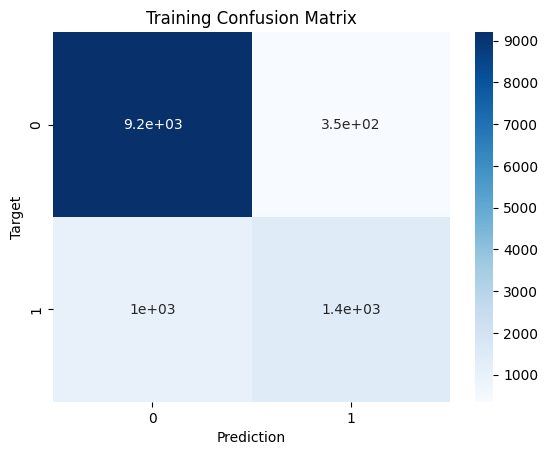

Area under ROC score on Validation dataset: 0.76%


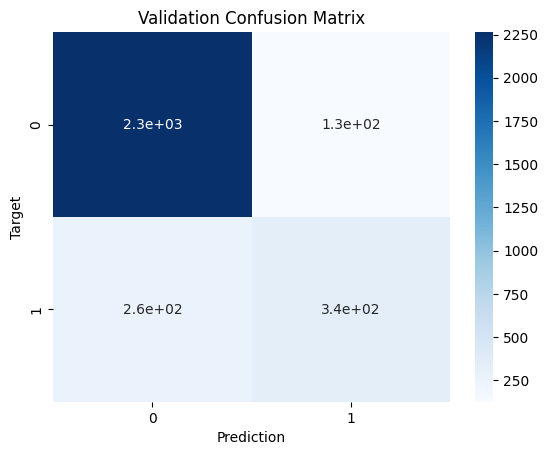

['logistic_regression_model.joblib']

In [4]:
#Читання даних з файлу
raw_df = pd.read_csv(train_csv, index_col=0)

#Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних
train_df, val_df = train_test_split(raw_df,
    test_size=0.2,
    random_state=42,
    stratify=raw_df['Exited']
)

# Створюємо трен. і вал. набори
input_cols = list(raw_df.columns)[1:-1]
target_col = 'Exited'
train_inputs = train_df[input_cols].copy()
val_inputs = val_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_targets = val_df[target_col].copy()

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Додаємо Imputer
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Додаємо Imputer
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Стоврюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42)) # Використовуємо LogisticRegression
])

# Тренуємо пайплайн
model_pipeline.fit(train_inputs, train_targets)

# Функція, щоб передбачати і рахувати метрики
def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds)
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, name='Training')
val_preds = predict_and_plot(model_pipeline, val_inputs, val_targets, name='Validation')

# Зберігаємо модель для подальшого використання
joblib.dump(model_pipeline, 'logistic_regression_model.joblib')



In [5]:
X_train = train_df[input_cols].copy()
y_train = train_df[target_col].copy()
X_val = val_df[input_cols].copy()
y_val = val_df[target_col].copy()

In [6]:
x = np.array([1, 2, 3, 4, 5])
y = np.array([2, 4, 5, 4, 5])

In [7]:
np.mean(x), np.std(x)

(np.float64(3.0), np.float64(1.4142135623730951))

In [8]:
# Apply the preprocessor to the training and validation data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

model = LinearRegression()
# Fit the model on the processed data
model.fit(X_train_processed, y_train)

# Make predictions on the processed data
y_pred_train = model.predict(X_train_processed)
y_pred_val = model.predict(X_val_processed)

print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred_val)))

Train RMSE:  0.31000479842163725
Test RMSE:  0.3365178243020768


In [9]:
test_df = pd.read_csv(data_dir + '/test.csv')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?

Area under ROC score on Training (with Polynomial Features) dataset: 0.80%


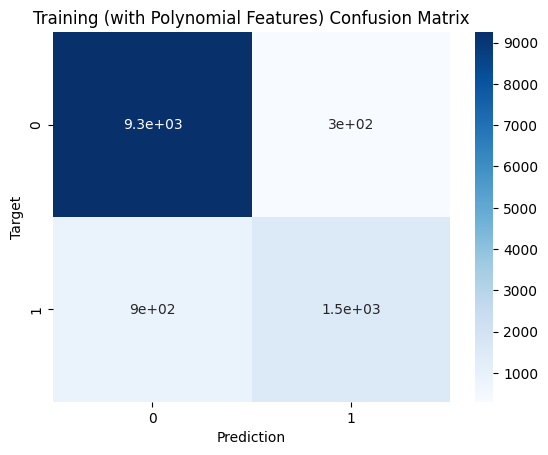

Area under ROC score on Validation (with Polynomial Features) dataset: 0.79%


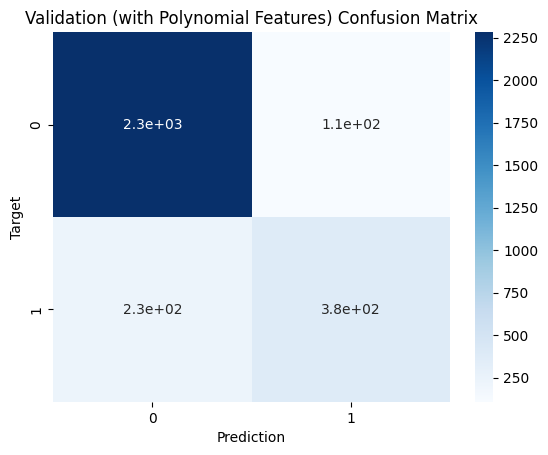

['logistic_regression_poly_model.joblib']

In [10]:
from sklearn.preprocessing import PolynomialFeatures

# Створюємо новий трансформер для числових колонок з поліноміальними ознаками
numeric_transformer_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)) # Додаємо PolynomialFeatures
])

# Комбінуємо новий трансформер для числових колонок з трансформером для категоріальних колонок
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створюємо новий пайплайн з новим препроцесором
model_pipeline_poly = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо новий пайплайн
model_pipeline_poly.fit(train_inputs, train_targets)

# Оцінюємо нову модель на трен і вал даних
train_preds_poly = predict_and_plot(model_pipeline_poly, train_inputs, train_targets, name='Training (with Polynomial Features)')
val_preds_poly = predict_and_plot(model_pipeline_poly, val_inputs, val_targets, name='Validation (with Polynomial Features)')

# Зберігаємо нову модель
joblib.dump(model_pipeline_poly, 'logistic_regression_poly_model.joblib')

Аналіз моделі з поліноміальними ознаками:
Метрики на тренувальному та валідаційному наборах значно покращились.
Модель демонструє невеликий overfit, оскільки вона краще працює на тренувальних даних, ніж на валідаційних.
Генералізація моделі не значно покращилась порівняно з моделлю без поліноміальних ознак.
Можливо, додавання поліноміальних ознак вищого ступеня або для інших комбінацій ознак може мати більший вплив.

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.

Area under ROC score on Training (with Polynomial Features degree 4) dataset: 0.83%


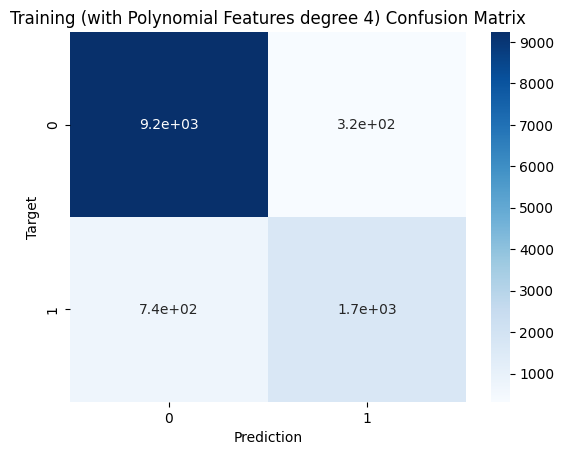

Area under ROC score on Validation (with Polynomial Features degree 4) dataset: 0.81%


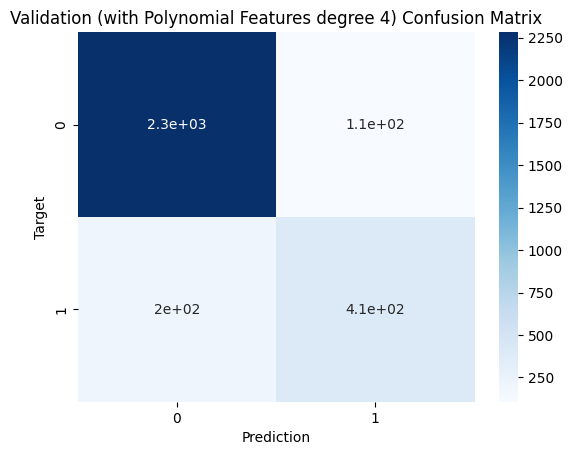

['logistic_regression_poly4_model.joblib']

In [11]:
# Створюємо новий трансформер для числових колонок з поліноміальними ознаками до степені 4
numeric_transformer_poly4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=4, include_bias=False)) # Додаємо PolynomialFeatures до степені 4
])

# Комбінуємо новий трансформер для числових колонок з трансформером для категоріальних колонок
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створюємо новий пайплайн з новим препроцесором
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо новий пайплайн
model_pipeline_poly4.fit(train_inputs, train_targets)

# Оцінюємо нову модель на трен і вал даних
train_preds_poly4 = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, name='Training (with Polynomial Features degree 4)')
val_preds_poly4 = predict_and_plot(model_pipeline_poly4, val_inputs, val_targets, name='Validation (with Polynomial Features degree 4)')

# Зберігаємо нову модель
joblib.dump(model_pipeline_poly4, 'logistic_regression_poly4_model.joblib')

Аналіз моделі з поліноміальними ознаками до степені 4:
При збільшенні степені поліноміальних ознак до 4, метрики на тренувальному та валідаційному наборах покращилися ще більше порівняно з степенем 2.
Значного overfit немає, тому що метрики на валідаційному наборі не сильно відрізняються від метрик тренувального набору.
Модель буде добре генералізувати на нових, невидимих даних.
Оскільки результати на валідації покращилися порівняно з моделями без поліноміальних ознак та з поліномом степені 2, то ця модель є кращою.

In [12]:
import pandas as pd
test_df = pd.read_csv(data_dir + '/test.csv')

In [13]:
sample_submission_df = pd.read_csv(data_dir + '/sample_submission.csv')

# Predict probabilities on the test data using the best model (model_pipeline_poly4)
test_inputs = test_df[input_cols].copy()
test_predictions_proba = model_pipeline_poly4.predict_proba(test_inputs)[:, 1]

submission_df = pd.DataFrame({'id': test_df['id'], 'Exited': test_predictions_proba})

# Save the submission file
submission_df.to_csv('submission_poly4.csv', index=False)

print("\nSubmission file 'submission_poly4.csv' created successfully.")
print("You can now upload this file to Kaggle.")


Submission file 'submission_poly4.csv' created successfully.
You can now upload this file to Kaggle.


Area under ROC score on Training (with Polynomial Features degree 7) dataset: 0.84%


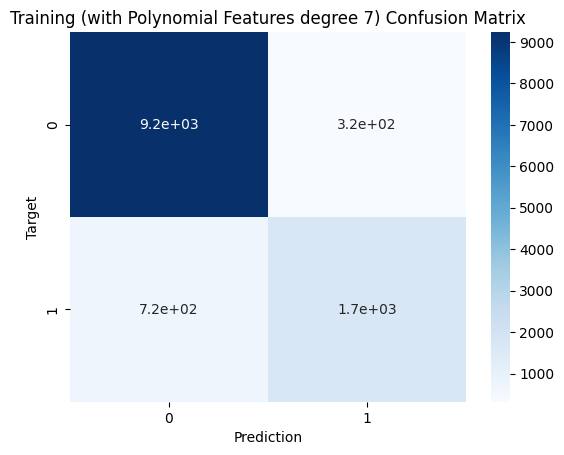

Area under ROC score on Validation (with Polynomial Features degree 7) dataset: 0.81%


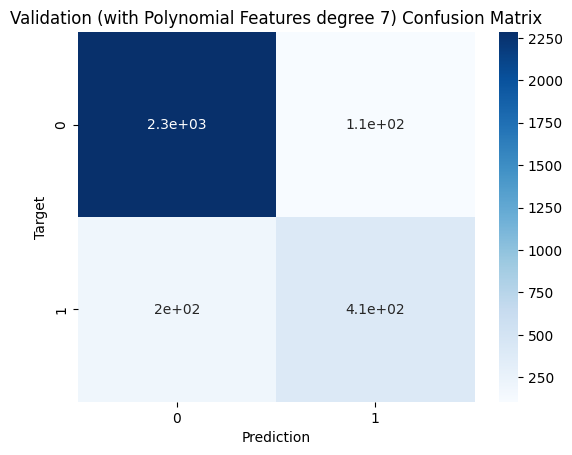

['logistic_regression_poly7_model.joblib']

In [14]:
# Створюємо новий трансформер для числових колонок з поліноміальними ознаками до степені 7
numeric_transformer_poly7 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=7, include_bias=False)) # Додаємо PolynomialFeatures до степені 7
])

# Комбінуємо новий трансформер для числових колонок з трансформером для категоріальних колонок
preprocessor_poly7 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly7, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створюємо новий пайплайн з новим препроцесором
model_pipeline_poly7 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly7),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42))
])

# Тренуємо новий пайплайн
model_pipeline_poly7.fit(train_inputs, train_targets)

# Оцінюємо нову модель на трен і вал даних
train_preds_poly7 = predict_and_plot(model_pipeline_poly7, train_inputs, train_targets, name='Training (with Polynomial Features degree 7)')
val_preds_poly7 = predict_and_plot(model_pipeline_poly7, val_inputs, val_targets, name='Validation (with Polynomial Features degree 7)')

# Зберігаємо нову модель
joblib.dump(model_pipeline_poly7, 'logistic_regression_poly7_model.joblib')

In [15]:
sample_submission_df = pd.read_csv(data_dir + '/sample_submission.csv')

# Predict probabilities on the test data using the best model (model_pipeline_poly7)
test_inputs = test_df[input_cols].copy()
test_predictions_proba = model_pipeline_poly7.predict_proba(test_inputs)[:, 1]

submission_df = pd.DataFrame({'id': test_df['id'], 'Exited': test_predictions_proba})

# Save the submission file
submission_df.to_csv('submission_poly7.csv', index=False)

print("\nSubmission file 'submission_poly7.csv' created successfully.")
print("You can now upload this file to Kaggle.")


Submission file 'submission_poly7.csv' created successfully.
You can now upload this file to Kaggle.


**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?


In [16]:
# Завантажуємо набір даних regression_data.csv
from google.colab import drive
drive.mount('/content/drive')
regression_df = pd.read_csv("drive/MyDrive/Machine_Learning/regression_data.csv")

# Розбиваємо на train і test (в тест 20%)
from sklearn.model_selection import train_test_split
reg_train_df, reg_test_df = train_test_split(regression_df, test_size=0.2, random_state=42)

# Визначаємо вхідні та цільові колонки для регресійної задачі
reg_input_cols = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5']
reg_target_col = ['target']

reg_train_inputs = reg_train_df[reg_input_cols]
reg_train_targets = reg_train_df[reg_target_col]
reg_test_inputs = reg_test_df[reg_input_cols]
reg_test_targets = reg_test_df[reg_target_col]

# Створюємо трансформер для числових ознак з масштабуванням та поліноміальними ознаками до степені 5
reg_numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)) # Поліноміальні ознаки до степені 5
])

# Створюємо препроцесор для регресійної задачі
reg_preprocessor = ColumnTransformer(
    transformers=[
        ('num', reg_numeric_transformer, reg_input_cols)
    ])

# Створюємо пайплайн для лінійної регресії
reg_model_pipeline = Pipeline(steps=[
    ('preprocessor', reg_preprocessor),
    ('regressor', LinearRegression()) # Лінійна регресія
])

# Тренуємо пайплайн на тренувальних даних
reg_model_pipeline.fit(reg_train_inputs, reg_train_targets)

# Функція для оцінки регресійної моделі
def evaluate_regression_model(model, inputs, targets, name=''):
    preds = model.predict(inputs)
    mse = mean_squared_error(targets, preds) # Використовуємо MSE
    rmse = np.sqrt(mse) # Обчислюємо RMSE вручну
    print(f"RMSE on {name} dataset: {rmse:.2f}")
    return preds

# Оцінюємо модель на тренувальних та тестових даних
reg_train_preds = evaluate_regression_model(reg_model_pipeline, reg_train_inputs, reg_train_targets, name='Training')
reg_test_preds = evaluate_regression_model(reg_model_pipeline, reg_test_inputs, reg_test_targets, name='Testing')

Mounted at /content/drive
RMSE on Training dataset: 0.00
RMSE on Testing dataset: 17.35


Висновок про якість регресійної моделі:
RMSE на тренувальному наборі значно нижчий, ніж на тестовому, що свідчить про overfit.
Модель перенавчена на тренувальних даних з високою степеню поліноміальних ознак.
І тому, модель не є хорошою і не добре генералізує.

**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [17]:
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
import numpy as np

# Створюємо новий трансформер для числових ознак з масштабуванням та поліноміальними ознаками до степені 20
reg_numeric_transformer_poly20 = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=20, include_bias=False)) # Поліноміальні ознаки до степені 20
])

# Створюємо препроцесор для регресійної задачі з поліноміальними ознаками до степені 20
reg_preprocessor_poly20 = ColumnTransformer(
    transformers=[
        ('num', reg_numeric_transformer_poly20, reg_input_cols)
    ])

# Створюємо пайплайн для Lasso
reg_model_pipeline_lasso = Pipeline(steps=[
    ('preprocessor', reg_preprocessor_poly20),
    ('regressor', Lasso(alpha=0.1, random_state=42, max_iter=10000)) # Lasso регресія з регуляризацією
])

# Створюємо пайплайн для Ridge
reg_model_pipeline_ridge = Pipeline(steps=[
    ('preprocessor', reg_preprocessor_poly20),
    ('regressor', Ridge(alpha=1.0, random_state=42)) # Ridge регресія з регуляризацією
])

# Створюємо пайплайн для ElasticNet
reg_model_pipeline_elasticnet = Pipeline(steps=[
    ('preprocessor', reg_preprocessor_poly20),
    ('regressor', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)) # ElasticNet регресія з регуляризацією
])

# Тренуємо моделі
print("Тренуємо Lasso модель:")
reg_model_pipeline_lasso.fit(reg_train_inputs, reg_train_targets)

print("\nТренуємо Ridge модель:")
reg_model_pipeline_ridge.fit(reg_train_inputs, reg_train_targets)

print("\nТренуємо ElasticNet модель:")
reg_model_pipeline_elasticnet.fit(reg_train_inputs, reg_train_targets)

# Оцінюємо моделі
print("\nОцінка моделей з поліноміальними ознаками до степені 20:")
print("\nLasso:")
reg_train_preds_lasso = evaluate_regression_model(reg_model_pipeline_lasso, reg_train_inputs, reg_train_targets, name='Training (Lasso)')
reg_test_preds_lasso = evaluate_regression_model(reg_model_pipeline_lasso, reg_test_inputs, reg_test_targets, name='Testing (Lasso)')

print("\nRidge:")
reg_train_preds_ridge = evaluate_regression_model(reg_model_pipeline_ridge, reg_train_inputs, reg_train_targets, name='Training (Ridge)')
reg_test_preds_ridge = evaluate_regression_model(reg_model_pipeline_ridge, reg_test_inputs, reg_test_targets, name='Testing (Ridge)')

print("\nElasticNet:")
reg_train_preds_elasticnet = evaluate_regression_model(reg_model_pipeline_elasticnet, reg_train_inputs, reg_train_targets, name='Training (ElasticNet)')
reg_test_preds_elasticnet = evaluate_regression_model(reg_model_pipeline_elasticnet, reg_test_inputs, reg_test_targets, name='Testing (ElasticNet)')

print("\nПорівняння з лінійною регресією (поліноміальні ознаки до степені 5):")
# Для порівняння, виведемо результати лінійної регресії зі степенем 5 ще раз
print("\nLinear Regression (Polynomial Features degree 5):")
evaluate_regression_model(reg_model_pipeline, reg_train_inputs, reg_train_targets, name='Training (Linear Regression)')
evaluate_regression_model(reg_model_pipeline, reg_test_inputs, reg_test_targets, name='Testing (Linear Regression)')

Тренуємо Lasso модель:

Тренуємо Ridge модель:

Тренуємо ElasticNet модель:

Оцінка моделей з поліноміальними ознаками до степені 20:

Lasso:
RMSE on Training (Lasso) dataset: 1.20
RMSE on Testing (Lasso) dataset: 1.00

Ridge:
RMSE on Training (Ridge) dataset: 5.89
RMSE on Testing (Ridge) dataset: 7.02

ElasticNet:
RMSE on Training (ElasticNet) dataset: 12.41
RMSE on Testing (ElasticNet) dataset: 11.95

Порівняння з лінійною регресією (поліноміальні ознаки до степені 5):

Linear Regression (Polynomial Features degree 5):
RMSE on Training (Linear Regression) dataset: 0.00
RMSE on Testing (Linear Regression) dataset: 17.35


array([[ 22.75848557],
       [-61.91124656],
       [ 21.51847895],
       [ 89.66563658],
       [-31.39578847],
       [-20.90324559],
       [-59.91256243],
       [ 72.18797034],
       [ 21.16941513],
       [ 18.69232586],
       [ 92.27341405],
       [ -4.53746712],
       [  4.12027234],
       [ 37.31275188],
       [-27.1664074 ],
       [ 37.70771194],
       [-39.41355749],
       [ 20.79466807],
       [ -8.54706935],
       [ 60.53804128],
       [ 22.09036433],
       [-59.84270098],
       [ -8.19484348],
       [  3.74788739],
       [ 11.85091463],
       [-19.78580095]])

Висновок про моделі Lasso, Ridge, ElasticNet з поліноміальними ознаками до степені 20:
При використанні поліноміальних ознак до степені 20 без регуляризації (як у випадку звичайної лінійної регресії), модель майже гарантовано буде сильно перенавчена.

Найкраще генералізує модель з регуляризацією Lasso.
RMSE on Training (Lasso) dataset: 1.20
RMSE on Testing (Lasso) dataset: 1.00

Має найменшу різницю між RMSE на тренувальному та тестовому наборах, а також низький абсолютний RMSE на тестовому наборі.
Модель найкраще впоралася з перенавчанням, спричиненим високою степеню поліноміальних ознак.